In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Partie 1 : Chargement des données

In [2]:
def fetch_data(path, data='train'):
    file_inputs=path+data+'/X_'+data+'.txt'
    df_X = pd.read_csv(file_inputs, header=None, delim_whitespace=True)
    X = df_X.values
    
    file_output=path+data+'/Y_'+data+'.txt'
    df_Y = pd.read_csv(file_output, header=None, delim_whitespace=True)
    Y = df_Y.values[:,0]
    
    return X, Y

In [4]:
# Données
# Telecharger et décompresser le fichier sur 
# https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip
    
# données apprentissage
path='C:/Users/PC Maison/7-OPENCLASSROOM/OC-COURS-24-APPRENTISSAGE-STATISTIQUE_OBJETS_CONNECTES/' #mettre le bon chemin vers le fichier sur votre disque
X_train, Y_train = fetch_data(path, data='train')

n, p = X_train.shape
print("Données d'apprentissage contiennent = {} points et {} variables".format(n, p))

# données de test
X_test, Y_test = fetch_data(path, data='test')

n, p = X_test.shape
print("Données d'apprentissage contiennent = {} points et {} variables".format(n, p))

Données d'apprentissage contiennent = 7767 points et 561 variables
Données d'apprentissage contiennent = 3162 points et 561 variables


## Partie 2 : Analyse des données

### Cardinalité des classes

Nom des classes : ['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING' 'STAND_TO_SIT' 'SIT_TO_STAND' 'SIT_TO_LIE' 'LIE_TO_SIT'
 'STAND_TO_LIE' 'LIE_TO_STAND']


C:\Users\Outils\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Outils\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


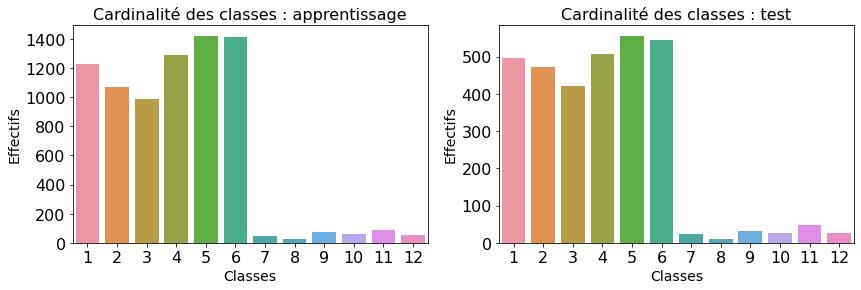

In [5]:
# nom des classes
df = pd.read_csv(path+'activity_labels.txt', header=None, delim_whitespace=True) 
nom_classes = df.values[:,1]
print("Nom des classes : {}".format(nom_classes))

plt.figure(figsize =(14, 4))
plt.subplot(121)
sns.countplot(Y_train, orient="v")
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.title("Cardinalité des classes : apprentissage",fontsize = 16)
plt.xlabel('Classes',fontsize = 14); plt.ylabel("Effectifs",fontsize = 14);

plt.subplot(122)
sns.countplot(Y_test, orient="v")
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.title("Cardinalité des classes : test",fontsize = 16)
plt.xlabel('Classes',fontsize = 14), plt.ylabel("Effectifs",fontsize = 14);

#### Commentez les graphiques obtenus

C'est un problème de classification multi-classe à 6 classes. Les 6 premières classes sont globalement équilibrées en termes de nombre d'exemples alors que les 6 classes suivantes sont minoritaires. 

## Partie 3 : Réalisez une classification

Comme un exemple nous allons faire une première classification en utilisant la régression logistique linéaire avec une pénalisation ridge. Le pipeline du modèle est le suivant 

$x \longrightarrow$  $\Big [$normalisation de $x$ :   $ x \leftarrow (x - \bar{x})/\sigma$ $\Big]$ $\longrightarrow$ $\Big[$ Modèle $f(x) = \beta^\top x + \beta_0$ $\Big]$ $\longrightarrow$ Prédiction $\hat{y}$

Les paramètres du modèle seront estimés en minimisant un terme + une régularisation ridge
$$
\min_{\beta_0, \, \beta}  \quad \|\beta\|^2 + C \sum_{i=1}^n L(x_i, f(x_i))
$$
(on remarquera que $C=1/\lambda$ par rapport au formalisme du cours)

### Définition du pipeline

In [6]:
from sklearn import preprocessing, linear_model
from sklearn.pipeline import Pipeline

# module de normalisation des entrées
normaliseur = preprocessing.StandardScaler()

# module de classification multi-classe avec une pénalité ridge
classifieur = linear_model.LogisticRegression(multi_class='auto', penalty='l2', solver='newton-cg')

# le pipeline
pipeline_reglog = Pipeline(steps=[('normalisation', normaliseur), ('reglog', classifieur)])

#### Question 
Pourquoi faut-il normaliser les données avant de faire le modèle de régression logistique ?

#### Réponse
Pour mettre à la même échelle les variables explicatives. L'importance d'une variable dans le modèle ne dépendra pas de son échelle mais de sa "corrélation" avec la sortie à prédire. 
* Remarque :
on notera ici que la normalisation peut être omise car les données fournies ont été réduites dans l'intervalle [-1, 1].



### Elaboration du modèle

Le modèle dépend du choix de $C$.  Pour cela on va faire une procédure de validation croisée pour apprendre le meilleur modèle en explorant plusieurs valeurs de $C$ sur une échelle logarithmique. La mesure de performance sera le taux de bonne classification ($accuracy$).

In [7]:
from sklearn.model_selection import GridSearchCV

# parametres
vecteur_C = np.logspace(-3, 3, 10)
parametres = {'reglog__C':vecteur_C}

# la validation croisée
modele = GridSearchCV(pipeline_reglog, param_grid=parametres, cv=2, scoring='accuracy', verbose=2, n_jobs=3)
modele.fit(X_train, Y_train)

# paramètre C correspondant au meilleur model
print("Meilleur paramètre C trouvé = {}".format(modele.best_params_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:   40.4s finished


Meilleur paramètre C trouvé = {'reglog__C': 0.46415888336127775}


### Analyse des résultats de la validation croisée
Visualisation de la courbe de validation utilisée pour sélectionner le meilleur modèle

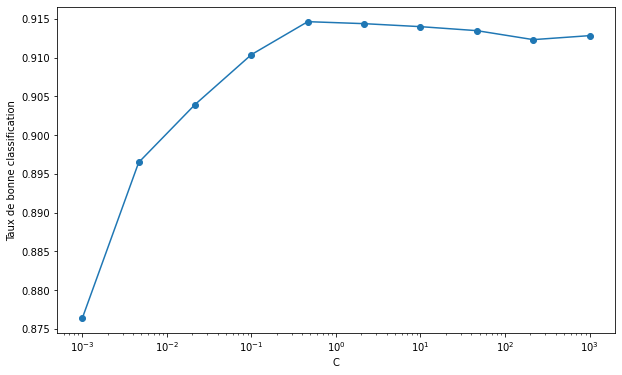

In [8]:
plt.figure(figsize=(10,6))
plt.semilogx(vecteur_C, modele.cv_results_['mean_test_score'], 'o-')
plt.xlabel('C'); plt.ylabel('Taux de bonne classification');

### Question 
A quel taux de bonne classification en validation correspond le "meilleur" paramètre $C$ ? 

#### Réponse
On constate que la meilleure valeur de $C$ sélectionnée correspond au maximum de la courbe de validation croisée c'est-à-dire au meilleur taux de bonne classification sur les données de validation.


### Evaluation des performances de généralisation du modèle
On évalue le modèle final sur les données de test

Taux de bonne classification en test : 93.90%


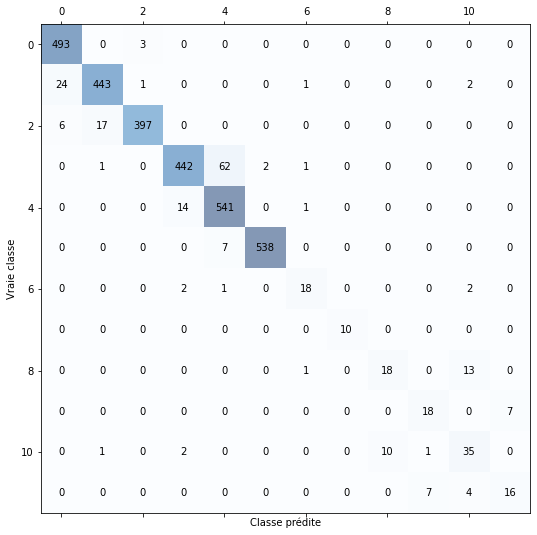

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score


Y_test_pred = modele.predict(X_test)
confmat = confusion_matrix(Y_test, Y_test_pred)

print('Taux de bonne classification en test : {:2.2f}%'.format(100*accuracy_score(Y_test, Y_test_pred)))

fig, ax = plt.subplots(figsize=(9, 9))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Classe prédite'); plt.ylabel('Vraie classe');


## Partie 4 : réalisez une classification avec un SVM 

### Partie 4.1 : SVM linéaire

L'objectif dans un premier temps est de construire un SVM linéaire $f(x) = \beta_0 + x^\top \beta$ avec $x \in \mathbb{R}^d$ le vecteur des entrées, $\beta$ le vecteur des paramètres et $\beta_0$ le biais. 

En vous inspirant de la partie 3 : 
* construire le bon pipeline,
* sélectionner le meilleur modèle et évaluez ses performances. 

Indication : on peut se servir de la fonction sklearn.svm.SVC avec kernel = 'linear'

In [10]:
from sklearn.svm import SVC


# Pipeline pour la construction du modèle SVM Linéaire
# module de normalisation des entrées
normaliseur = preprocessing.StandardScaler()

# module de classification SVM multi-classe Linéaire
classifieur_svm_lin = SVC(kernel = 'linear')

# le pipeline
pipeline_svm = Pipeline(steps=[('normalisation', normaliseur), ('svm', classifieur_svm_lin)])

# parametres
vecteur_C = np.logspace(-3, 3, 10)
parametres = {'svm__C':vecteur_C}

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:   25.7s finished



SVM linéaire - Meilleur paramètre C trouvé = {'reglog__C': 0.46415888336127775}


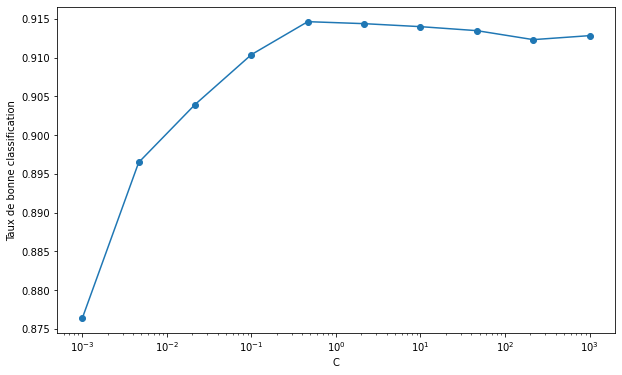

In [11]:
# la validation croisée
modele_svm = GridSearchCV(pipeline_svm, param_grid=parametres, cv=2, scoring='accuracy', verbose=2, n_jobs=3)
modele_svm.fit(X_train, Y_train)

# paramètre C correspondant au meilleur model
print("\nSVM linéaire - Meilleur paramètre C trouvé = {}".format(modele.best_params_))

# affichage des courbes de validation
plt.figure(figsize=(10,6))
plt.semilogx(vecteur_C, modele.cv_results_['mean_test_score'], 'o-')
plt.xlabel('C'), plt.ylabel('Taux de bonne classification');

SVM Linéaire - Taux de bonne classification en test : 94.34%


Text(0.5, 1.0, 'SVM Linéaire - Matrice de confusion')

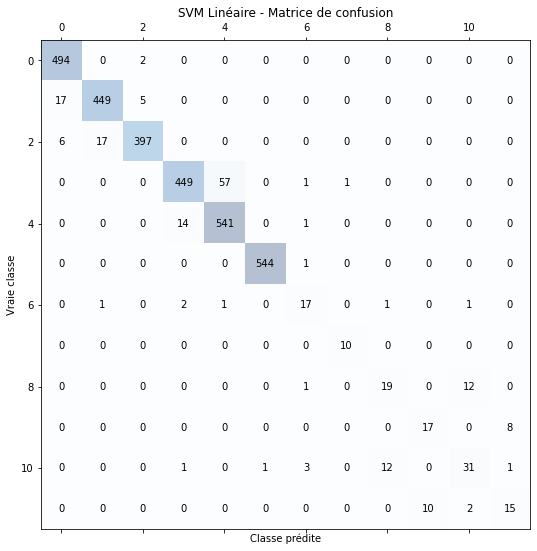

In [12]:
Y_test_pred = modele_svm.predict(X_test)
confmat = confusion_matrix(Y_test, Y_test_pred)

print('SVM Linéaire - Taux de bonne classification en test : {:2.2f}%'.format(100*accuracy_score(Y_test, Y_test_pred)))

fig, ax = plt.subplots(figsize=(9, 9))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Classe prédite'), plt.ylabel('Vraie classe');
plt.title("SVM Linéaire - Matrice de confusion")

### Partie 4.2 : SVM non-linéaire

Nous allons  maintenant explorer un SVM non-linéaire avec un noyau gaussian (rbf kernel). 
* Quels sont maintenant les hyper-paramètres à déterminer ?
* Adaptez le code de sélection du meilleur modèle
* Sélectionnez votre meilleur SVM non-linéaire et évaluez ses performances

In [13]:
# on change le module de classification en SVM non-linéaire avec 
# un noyau gaussien (kernel = 'rbf') de paramètre gamma
# module de classification SVM multi-classe Linéaire
# on a maintenant deux hyper-paramètres à trouver : 
# * le paramètre C 
# * l'hyper-paramètre gamma 

classifieur_svm_rbf = SVC(kernel = 'rbf')

# le pipeline
pipeline_svm = Pipeline(steps=[('normalisation', normaliseur), ('svm', classifieur_svm_rbf)])

# parametres
vecteur_C = np.logspace(-1, 3, 7) 
vecteur_gamma = np.logspace(-5, -2, 6)
parametres = {'svm__C':vecteur_C, 'svm__gamma':vecteur_gamma}

# la validation croisée
modele_svm = GridSearchCV(pipeline_svm, param_grid=parametres, cv=2, scoring='accuracy', verbose=2, n_jobs = 3)
modele_svm.fit(X_train, Y_train)

Fitting 2 folds for each of 42 candidates, totalling 84 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done  84 out of  84 | elapsed:  5.3min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('normalisation', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=3,
             param_grid={'svm__C': array([1.00000000e-01, 4.64158883e-01, 2.15443469e+00, 1.00000000e+01,
       4.64158883e+01, 2.15443469e+02, 1.00000000e+03]),
                         'svm__gamma': array([1.00000000e-05, 3.98107171e-05, 1.58489319e-04, 6.30957344e-04,
       2.51188643e-03, 1.00000000e-02])},
             scoring='accuracy', verbose=2)


 SVM non-linéaire - meilleurs hyper-paramètres trouvés = {'reglog__C': 0.46415888336127775}


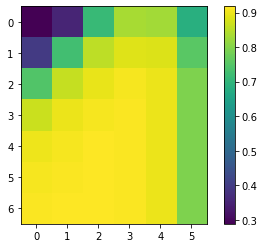

In [14]:
## Tracé figure erreur de validation en fonction de C et gamma
plt.imshow(modele_svm.cv_results_['mean_test_score'].reshape(vecteur_C.shape[0], vecteur_gamma.shape[0]))
plt.colorbar()

print("\n SVM non-linéaire - meilleurs hyper-paramètres trouvés = {}".format(modele.best_params_))

SVM rbf - Taux de bonne classification en test : 95.00%


Text(0.5, 1.0, 'SVM Rbf - Matrice de confusion')

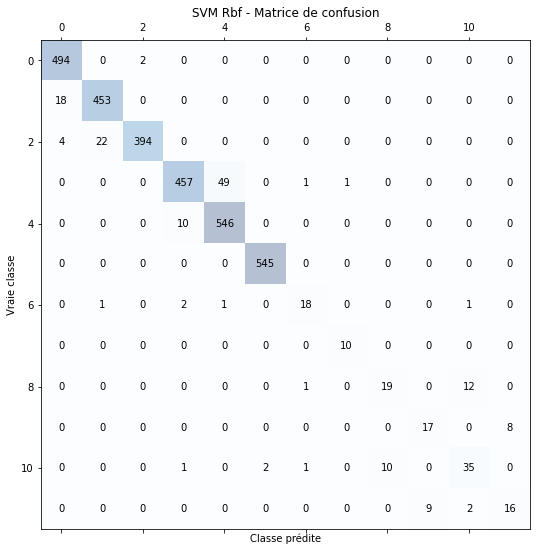

In [15]:
Y_test_pred = modele_svm.predict(X_test)
confmat = confusion_matrix(Y_test, Y_test_pred)

print('SVM rbf - Taux de bonne classification en test : {:2.2f}%'.format(100*accuracy_score(Y_test, Y_test_pred)))

fig, ax = plt.subplots(figsize=(9, 9))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Classe prédite'); plt.ylabel('Vraie classe');
plt.title("SVM Rbf - Matrice de confusion")

### Comparez les performances des 3 classifieurs et commentez

#### Commentaires 
Le modèle SVM linéaire en termes d'accuracy améliore les performnces de la régression logistique. Le SVM non-linéaire par rapport à sa version linéaire apporte une très petite amélioration. Cela se voit également sur les matrices de confusion où on constate que le SVM non-linéaire améliore légèrement le taux de bonne détection de chaque classe.

